- Build an AI Image Caption Recommendation System using a retrieval-based approach, leveraging CLIP (Contrastive Language–Image Pre-training) for both image and text understanding.

- First, the input image will be preprocessed and fed into the CLIP image encoder to generate a high-dimensional feature vector representing the image’s visual content. A similar process will be applied to a set of candidate captions, using the CLIP text encoder to generate text embeddings for each caption. Next, the cosine similarity between the image embedding and each caption embedding will be calculated. This similarity score will quantify how well each caption aligns with the visual content of the image.

- Finally, the system ranks the candidate captions based on their similarity scores and presents the top-ranked captions as recommendations.

https://thecleverprogrammer.com/2025/02/11/ai-image-caption-recommendation-system/

In [16]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, AutoProcessor, AutoModelForCausalLM
from sklearn.metrics.pairwise import cosine_similarity 
import warnings
warnings.filterwarnings("ignore")

{'pixel_values': tensor([[[[-1.5149, -1.5149, -1.4857,  ..., -1.3835, -1.4127, -1.4127],
          [-1.5587, -1.5441, -1.5149,  ..., -1.3835, -1.4127, -1.4273],
          [-1.5879, -1.5733, -1.5587,  ..., -1.3835, -1.4273, -1.4565],
          ...,
          [ 0.6457,  1.0836,  1.4048,  ..., -0.7996, -0.7996, -0.7850],
          [-1.1499, -0.8142, -0.2156,  ..., -0.8726, -0.8580, -0.8434],
          [-1.4857, -1.4711, -1.3689,  ..., -0.9310, -0.9164, -0.8872]],

         [[-1.3169, -1.3169, -1.2869,  ..., -1.3169, -1.3469, -1.3469],
          [-1.3619, -1.3469, -1.3169,  ..., -1.3169, -1.3469, -1.3619],
          [-1.3919, -1.3769, -1.3619,  ..., -1.3169, -1.3619, -1.3919],
          ...,
          [ 0.4991,  1.0093,  1.3695,  ..., -0.2963, -0.2963, -0.2663],
          [-1.3469, -0.9567, -0.3114,  ..., -0.3714, -0.3414, -0.3264],
          [-1.4970, -1.5270, -1.4669,  ..., -0.4314, -0.4014, -0.3714]],

         [[-1.1816, -1.1816, -1.1532,  ..., -0.9967, -1.0252, -1.0252],
          [-1

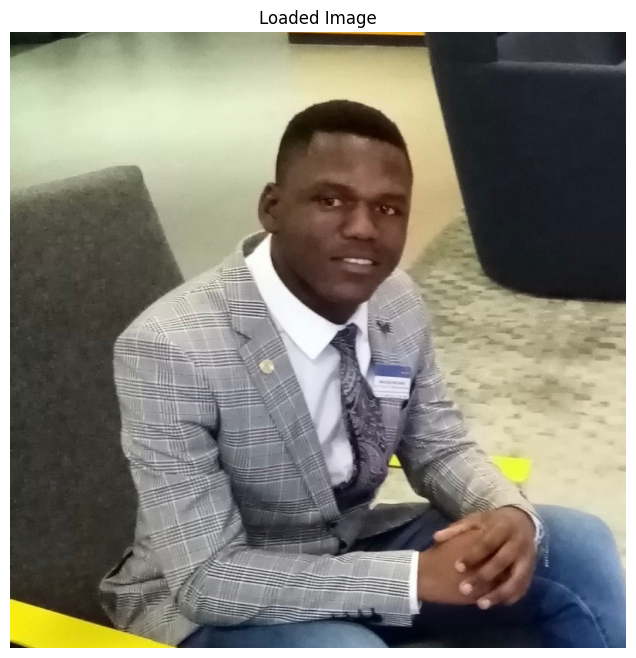

In [11]:
import torch
from PIL import Image
from transformers import CLIPProcessor
import matplotlib.pyplot as plt

# image loading and preprocessing
def load_and_preprocess_image(image_path):
    """
    This function opens the image using PIL, converts it to RGB format (important for consistency), 
    and then uses the CLIPProcessor to transform the image into a format suitable for the CLIP model. 
    The processor handles resizing, normalization, and other necessary transformations. 
    The output will be a PyTorch tensor ready for CLIP.
    """
    image = Image.open(image_path).convert("RGB")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    inputs = processor(images=image, return_tensors="pt")
    return inputs, processor, image  # Return original image as well

# Load and preprocess the image
image_path = '/Users/mncedisimncwabe/Downloads/1603816521799.jpeg'
inputs, processor, original_image = load_and_preprocess_image(image_path)
print(inputs)

# Display the original image
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.axis('off')
plt.title('Loaded Image')
plt.show()

In [12]:
# image understanding with CLIP
def generate_image_embeddings(inputs):
    """
    This function loads the pre-trained CLIP model. The crucial step here is model.get_image_features(**inputs), 
    which passes the preprocessed image tensor to the CLIP model and extracts a high-dimensional feature vector representing 
    the images visual content. torch.no_grad() is used to prevent gradient calculations during inference, 
    saving memory and speeding up the process.
    """
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)

    return image_features, model

image_features, model = generate_image_embeddings(inputs)
print(image_features)
print(model)

tensor([[-4.8556e-01, -2.8726e-01, -1.3673e-01, -7.3911e-02,  8.9069e-02,
         -3.4057e-02,  4.7849e-01,  4.9580e-01,  1.0160e+00,  4.7774e-02,
          3.8565e-01,  3.6918e-01, -1.6300e-01, -8.2227e-02,  2.8392e-01,
          3.1917e-01,  2.1673e+00,  5.2460e-02,  2.5881e-02,  6.4760e-01,
          1.2625e+00,  1.2740e-01, -4.4826e-02,  4.7397e-01, -2.2309e-01,
         -1.6804e-01, -7.9700e-02, -3.0685e-02, -1.2822e-01,  3.5716e-02,
          5.8247e-03,  2.5644e-01, -1.7193e-01,  5.9398e-01,  6.7693e-02,
         -3.5688e-02, -4.6619e-02, -2.9192e-01,  2.9381e-01, -1.6733e-01,
         -3.8898e-01, -1.8615e-01,  5.9565e-01, -8.7347e-02, -1.7155e-02,
          9.7404e-01,  5.9290e-01,  4.7340e-01,  1.4781e-01,  1.0343e-02,
          5.4960e-02,  3.6742e-01,  3.8515e-01,  2.0931e-01, -2.6425e-01,
          1.4718e-01,  5.4670e-01,  2.2559e-01,  3.5311e-02,  1.2684e-01,
         -3.9061e-02, -4.8395e-02, -2.1785e-01,  2.7644e-01, -2.6228e-01,
         -3.1232e-01,  4.5107e-02,  7.

In [13]:
# caption matching (using CLIP text embeddings)
def match_captions(image_features, captions, clip_model, processor):
    """
    This function takes the image features and a list of candidate captions as input. 
    It processes the captions using the same CLIPProcessor (now for text) to get text embeddings. 
    It then calculates the cosine similarity between the image embedding and each text embedding. 
    Cosine similarity measures the angle between two vectors; a value closer to 1 indicates higher similarity. 
    The function will return the captions ranked by similarity and their corresponding similarity scores.
    
    """
    # 1. get text embeddings for the captions:
    text_inputs = processor(text=captions, return_tensors="pt", padding=True)
    with torch.no_grad():
        text_features = clip_model.get_text_features(**text_inputs)

    # 2. calculate cosine similarity between image and text features:
    image_features = image_features.detach().cpu().numpy()
    text_features = text_features.detach().cpu().numpy()

    similarities = cosine_similarity(image_features, text_features)

    # 3. find the best matching captions:
    best_indices = similarities.argsort(axis=1)[0][::-1]  
    best_captions = [captions[i] for i in best_indices]

    return best_captions, similarities[0][best_indices].tolist()

In [17]:
candidate_captions = [
"Confidence in every detail.",
"Professional excellence personified.",
"Dressed for success.",
"The face of determination.",
"Ambition meets preparation.",
"Leadership starts with presence.",
"Making an impression that lasts.",
"Where professionalism meets personality.",
"Success begins with presentation.",
"The power of professional presence.",
"Ready for whatever business brings.",
"Excellence in every interaction.",
"Representing with distinction.",
"The art of professional poise.",
"Beyond the business attire.",
"Projecting confidence and capability.",
"Where preparation meets opportunity.",
"The standard of professionalism.",
"Elevating the professional experience.",
"Crafting a professional legacy.",
"The intersection of style and substance.",
"Poised for professional excellence.",
"The language of professional presence.",
"Where ambition meets action.",
"The blueprint for professional success."]

# main function
def image_captioning(image_path, candidate_captions):  
    inputs, processor, image = load_and_preprocess_image(image_path)
    image_features, clip_model = generate_image_embeddings(inputs)

    best_captions, similarities = match_captions(image_features, candidate_captions, clip_model, processor)
    return best_captions, similarities

best_captions, similarities = image_captioning(image_path, candidate_captions)

# get the top 5 results
top_n = min(5, len(best_captions))
top_best_captions = best_captions[:top_n]
top_similarities = similarities[:top_n]

print("Top 5 Best Captions:")
for i, (caption, similarity) in enumerate(zip(top_best_captions, top_similarities)):
    print(f"{i+1}. {caption} (Similarity: {similarity:.4f})")

Top 5 Best Captions:
1. Elevating the professional experience. (Similarity: 0.2447)
2. Poised for professional excellence. (Similarity: 0.2344)
3. Where professionalism meets personality. (Similarity: 0.2337)
4. Crafting a professional legacy. (Similarity: 0.2308)
5. Dressed for success. (Similarity: 0.2302)
